In [243]:
import asreview as asr

from asreview.models.balancers import Balanced
from asreview.models.queriers import Max

from asreview.models.classifiers import SVM
from asreviewcontrib.dory.classifiers.neural_networks import DynamicNNClassifier  # noqa:F401
from asreviewcontrib.dory.feature_extractors.transformer_embeddings import MXBAI

import numpy as np
import pandas as pd
from wordcloud import WordCloud as wc
from dataclasses import dataclass, field

In [193]:
data = asr.load_dataset(r"data\van_der_Valk_2021.csv")

alc = asr.ActiveLearningCycle(
    classifier=DynamicNNClassifier(),
    # classifier=SVM(max_iter=5000, loss="squared_hinge", C=0.067),  # classifier c(x)
    feature_extractor=MXBAI(normalize=False),
    balancer=Balanced(ratio = 9.724),
    querier=Max(),
)

In [16]:
embedding_matrix: np.ndarray = alc.transform(
    data
)  # h(x) turning the abstracts into matrix A

Embedding text...
Model 'mixedbread-ai/mxbai-embed-large-v1' has been loaded.


Batches:   0%|          | 0/23 [00:00<?, ?it/s]

In [34]:
embedding_matrix[0] == alc.transform(data.get_df().iloc[[0]])

Embedding text...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

array([[False, False, False, ..., False, False,  True]], shape=(1, 1024))

In [244]:
def normalize_embedding(fm) -> np.ndarray:
    return (fm - fm.min()) / (fm.max() - fm.min())

@dataclass
class EmbeddingNormalizer:
    base_embedding: np.ndarray
    embedding_min: float = field(init=False)
    embedding_max: float = field(init=False)

    def __post_init__(self):
        self.embedding_min = float(self.base_embedding.min())
        self.embedding_max = float(self.base_embedding.max())

    def normalize(self, embedding) -> np.ndarray:
        return (embedding - self.embedding_min) / (self.embedding_max - self.embedding_min)

embedding_normalizer = EmbeddingNormalizer(embedding_matrix)

normalized_embedding_matrix: np.ndarray = embedding_normalizer.normalize(embedding_matrix)

In [196]:
print("\n### Non-Negative Matrix ###")
simulate = asr.Simulate(  # c(A) in the cycler
    X=normalized_embedding_matrix,
    labels=data["included"],
    cycles=[alc],
    skip_transform=True,
)

simulate.label(list(range(10)))
simulate.review()


### Non-Negative Matrix ###


Records labeled       :  53%|█████▎    | 386/725 [07:30<06:46,  1.20s/it]


Loss: 0.172
NDCG: 0.705


In [197]:
def get_proba_from_cycle(X: np.ndarray, simulate: asr.Simulate = simulate):
    try:
        return simulate.cycles[0].classifier.predict_proba(X)

    except AttributeError:
        try:
            scores = simulate.cycles[0].classifier.decision_function(X).reshape(-1, 1)
            pos = np.maximum(scores, 0.0).reshape(-1, 1)
            neg = np.maximum(-scores, 0.0).reshape(-1, 1)
            return np.hstack([neg, pos])

        except AttributeError:
            raise AttributeError(
                "Not possible to compute probabilities or "
                "decision function for this classifier."
            )

# Cockatiel

In [224]:
from sklearn.decomposition import NMF
from cockatiel.cockatiel.sampling import ScipySobolSequence
from cockatiel.cockatiel.sobol import SobolEstimator, JansenEstimator
import matplotlib.pyplot as plt

In [231]:
n_components = 15

In [ ]:
# class JansenEstimator(SobolEstimator):
#     def __call__(self, masks, outputs, nb_design):
#         nb_dim = self.masks_dim(masks)
#         sampling_a, _, replication_c = self.split_abc(outputs, nb_design, nb_dim)
#         mu_a = np.mean(sampling_a)
#         var = np.sum([(v - mu_a) ** 2 for v in sampling_a]) / (len(sampling_a) - 1)
#         eps = 1e-12
#         if var < eps:
#             return np.zeros(nb_dim)
#         stis = [
#             np.sum((sampling_a - replication_c[i]) ** 2.0) / (2 * nb_design * var)
#             for i in range(nb_dim)
#         ]
#         return self.post_process(stis, masks)

In [233]:
factorization = NMF(n_components=n_components, max_iter=10000)

u_matrix: np.ndarray = factorization.fit_transform(
    normalized_embedding_matrix
)  # concept coefficient matrix
w_matrix: np.ndarray = factorization.components_  # concept base matrix

In [234]:
def sobol_importance(
    activations: np.ndarray,
    class_id: int,
    W: np.ndarray,
    components: int,
    sobol_nb_design: int = 32,
    # batch_size: int = 256
):
    n_samples = activations.shape[0]
    masks = ScipySobolSequence()(components, nb_design=sobol_nb_design)
    estimator = JansenEstimator()

    importances = []

    for i in range(n_samples):
        act = activations[i]

        perturbation = masks @ W
        perturbated_activations = act[None, :] + perturbation * act[None, :]
        y_pred = get_proba_from_cycle(perturbated_activations)[:, class_id]

        stis = estimator(masks, y_pred, sobol_nb_design)
        importances.append(stis)

    global_importance = np.mean(importances, axis=0)

    return global_importance


In [235]:
concept_importance_0 = sobol_importance(
    activations=normalized_embedding_matrix,
    class_id=0,
    W=w_matrix,
    components=factorization.n_components,
)
concept_importance_1 = sobol_importance(
    activations=normalized_embedding_matrix,
    class_id=1,
    W=w_matrix,
    components=factorization.n_components,
)

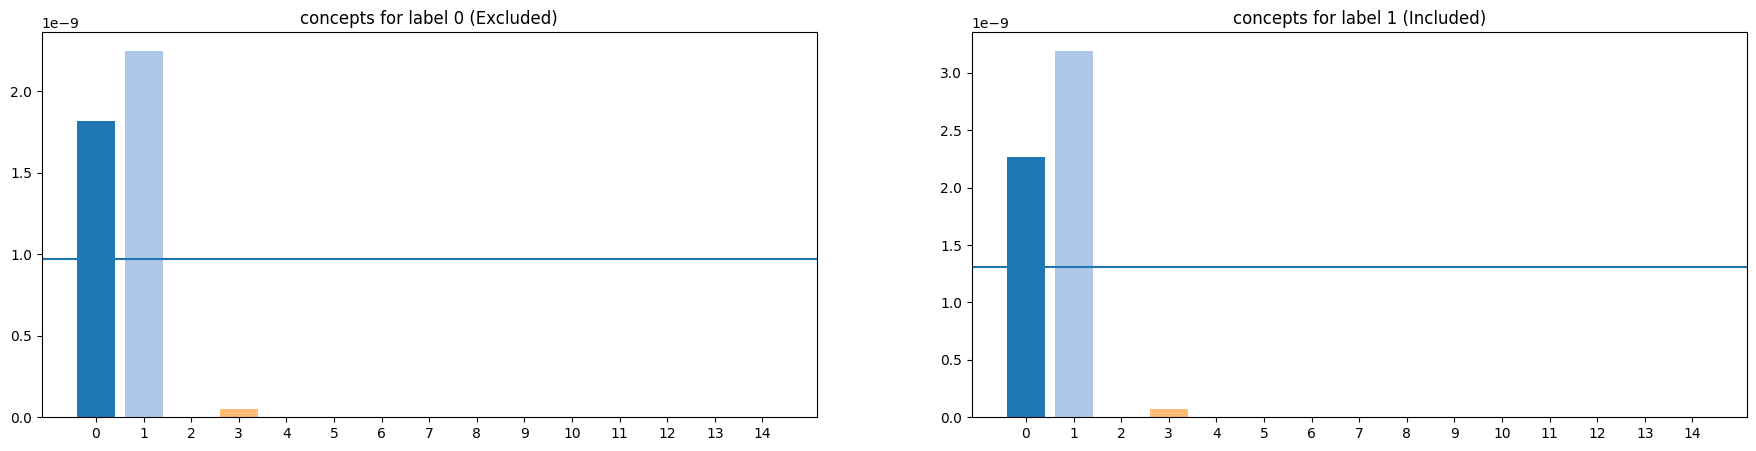

In [236]:
plt.figure(figsize=(22, 5))

plt.subplot(121)
plt.bar(
    range(len(concept_importance_0)),
    concept_importance_0,
    color=plt.get_cmap("tab20").colors,
    tick_label=range(len(concept_importance_0)),
)
plt.axhline(concept_importance_0.mean()+concept_importance_0.std())
plt.title("concepts for label 0 (Excluded)")

plt.subplot(122)
plt.bar(
    range(len(concept_importance_1)),
    concept_importance_1,
    color=plt.get_cmap("tab20").colors,
    tick_label=range(len(concept_importance_1)),
)
plt.axhline(concept_importance_1.std()+concept_importance_1.mean())
plt.title("concepts for label 1 (Included)")

plt.show()

In [ ]:
# finding abstracts that align with concepts
df = data.get_df()[["title", "abstract", "included"]]

# use the text merger part of the feature extractor to get the text column
df['text'] = simulate.cycles[0].feature_extractor.steps[0][1].transform(df[['title','abstract']])

df['u'] = list(u_matrix)

df.head(5)

,title,abstract,included,text,u
0,Diabetes mellitus and hypercortisolism in a cat,A fourteen-year-old Persian cat was referred b...,0,Diabetes mellitus and hypercortisolism in a ca...,"[0.008034855, 0.0085261, 0.1193312, 0.00695451..."
1,Unexpected Endocrine Features and Normal Pigme...,Proopiomelanocortin (POMC) is the precursor to...,0,Unexpected Endocrine Features and Normal Pigme...,"[0.007983661, 0.018589752, 0.0, 0.0138351545, ..."
2,Psychological Studies of Adult Male Patients w...,Excerpt This study explores some psychological...,0,Psychological Studies of Adult Male Patients w...,"[0.002835823, 0.0, 0.09263078, 0.0128466645, 0..."
3,Hair cortisol as a biological marker of chroni...,The detrimental effects of stress on human hea...,0,Hair cortisol as a biological marker of chroni...,"[0.006092414, 0.044426206, 0.08080066, 0.02997..."
4,"In adults with obesity, copeptin is linked wit...",Obesity and cardiometabolic diseases are assoc...,1,"In adults with obesity, copeptin is linked wit...","[0.024825593, 0.013369114, 0.069325164, 0.0270..."


## Concept-Aligned Abstract Selection

The following code selects abstracts aligned with important concepts for each class. This is intended to support the visualization of concept-based occlusion as done in the COCKATIEL paper.

In the paper, the authors describe this step as:

    “We take the first n most important sentences for each concept looked at.”

However, this wording is misleading.

What the code actually does:

    It first identifies the top-m most important concepts for each class (m_cls_0 and m_cls_1) using the Sobol importance scores.

    Then, for each of these top concepts, it selects the n abstracts from the corresponding class (0 or 1) that have the highest activation for that concept (i.e., the highest coefficient in the NMF U matrix).

    The result is a list of m × n abstracts per class that best represent the most influential concepts, according to NMF.

Key clarification:

    The abstracts are not ranked globally by importance or fidelity to the model’s prediction.

    Instead, they are selected per concept, based on how strongly each abstract activates that concept.

In [238]:
n = 15         # Top-n abstracts per concept

threshold_0 = np.mean(concept_importance_0) + np.std(concept_importance_0)
threshold_1 = np.mean(concept_importance_1) + np.std(concept_importance_1)

top_cids_0 = np.where(concept_importance_0 > threshold_0)[0]
top_cids_1 = np.where(concept_importance_1 > threshold_1)[0]

print(f"Selected {len(top_cids_0)} concepts for class 0")
print(f"Selected {len(top_cids_1)} concepts for class 1")

u_cls_0 = u_matrix[df["included"].to_numpy() == 0]
u_cls_1 = u_matrix[df["included"].to_numpy() == 1]
abs_cls_0 = df["text"].to_numpy()[df["included"].to_numpy() == 0]
abs_cls_1 = df["text"].to_numpy()[df["included"].to_numpy() == 1]

rows_cls_0 = []
rows_cls_1 = []

for cid in top_cids_0:
    best_ids = np.argsort(a=u_cls_0[:, cid])[::-1][:n]
    for i in best_ids:
        rows_cls_0.append({"text": abs_cls_0[i], "concept_id": cid})

for cid in top_cids_1:
    best_ids = np.argsort(a=u_cls_1[:, cid])[::-1][:n]
    for i in best_ids:
        rows_cls_1.append({"text": abs_cls_1[i], "concept_id": cid})

df_top_abs_cls_0 = pd.DataFrame(data=rows_cls_0)
df_top_abs_cls_1 = pd.DataFrame(data=rows_cls_1)

Selected 2 concepts for class 0
Selected 2 concepts for class 1


class 0
We excluded case reports, animal studies, review articles, non-English or nonpeer reviewed studies, and studies in which hair sampling 
and weight measurements were not performed simultaneously (Figure 1). Pediatric studies that only included children younger than age 2
 years were also excluded because BMI-based definitions of obesity are not available for this age group

Concept 0 for class 0


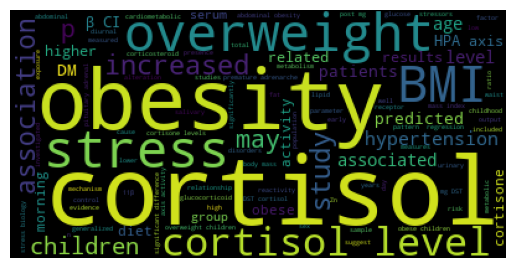

Concept 1 for class 0


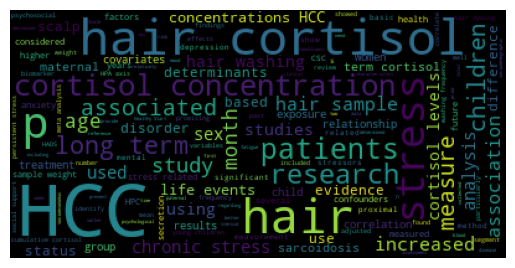

class 1
We included studies that reported cross-sectional associations between HairGC and measurements of obesity.

Concept 0 for class 1


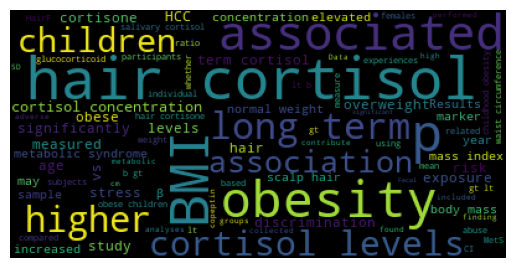

Concept 1 for class 1


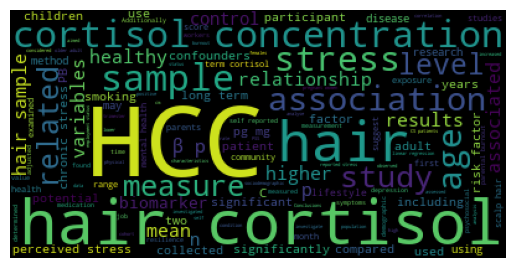

In [239]:
print("class 0\nWe excluded case reports, animal studies, review articles, non-English or nonpeer reviewed studies, and studies in which hair sampling \nand weight measurements were not performed simultaneously (Figure 1). Pediatric studies that only included children younger than age 2\n years were also excluded because BMI-based definitions of obesity are not available for this age group\n")

for concept in df_top_abs_cls_0.concept_id.unique():
    print(f"Concept {concept} for class 0")
    plt.imshow(X=wc().generate(text=" ".join(df_top_abs_cls_0[df_top_abs_cls_0['concept_id'] == concept].text)))
    plt.axis("off")
    plt.show()

print("class 1\nWe included studies that reported cross-sectional associations between HairGC and measurements of obesity.\n")

for concept in df_top_abs_cls_1.concept_id.unique():
    print(f"Concept {concept} for class 1")
    plt.imshow(X=wc().generate(text=" ".join(df_top_abs_cls_1[df_top_abs_cls_1['concept_id'] == concept].text)))
    plt.axis("off")
    plt.show()

# Occlusion

In [240]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download(info_or_id='punkt_tab')

simulate.cycles[0].feature_extractor.steps[1][1].verbose = False

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Jelle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [265]:
def occlude_concepts(row, simulate=simulate, factorization=factorization) -> pd.DataFrame:
    sentences = sent_tokenize(row["text"])

    perturbed_texts = [
        " ".join(s for j, s in enumerate(sentences) if j != i)
        for i in range(len(sentences))
    ]

    A_occluded = simulate.cycles[0].feature_extractor.steps[1][1].fit_transform(perturbed_texts)

    # 4) max-max using original values
    A_norm = embedding_normalizer.normalize(embedding=A_occluded)

    # project the whole batch to concept space
    U_occ = factorization.transform(A_norm)

    # ∆U: full – perturbed  (broadcasts row['u'])
    delta = row["u"] - U_occ

    #  package as dataframe
    concept_cols = [f"concept_{i}" for i in range(delta.shape[1])]
    out = pd.DataFrame(delta, columns=concept_cols)
    out.insert(0, "sentence", sentences)

    return out

In [268]:
occlude_concepts(df.iloc[0])

,sentence,concept_0,concept_1,concept_2,concept_3,concept_4,concept_5,concept_6,concept_7,concept_8,concept_9,concept_10,concept_11,concept_12,concept_13,concept_14
0,Diabetes mellitus and hypercortisolism in a ca...,0.001131,0.001991,-0.012455,-0.000898,0.000704,0.007080,-0.009334,0.014676,0.004863,-0.039892,-0.009454,0.0,0.013993,-0.013178,0.012450
1,Clinical signs were severe polydipsia/polyuria...,-0.001784,0.004353,-0.007031,-0.001500,-0.002717,-0.003306,0.002535,-0.015869,0.000175,0.029733,0.014504,0.0,0.014620,-0.012995,-0.018674
2,"At the time of initial presentation, he was tr...",0.000376,-0.001350,0.004787,-0.000913,-0.000558,0.002855,-0.004339,-0.012125,0.020304,0.023058,-0.002164,0.0,-0.003831,-0.013406,-0.004480
3,A low dose dexamethasone suppression test (LDD...,0.001106,0.001435,-0.002780,-0.002465,-0.000621,0.010197,-0.000976,-0.001862,0.008520,-0.032596,-0.011111,0.0,-0.008560,0.003559,0.007024
4,The cat was additionally treated with trilosta...,-0.000242,-0.000327,0.005994,0.001154,-0.002245,0.005182,-0.000140,0.002521,0.003649,0.010266,-0.015799,0.0,-0.004708,-0.008005,-0.002359
5,This case illustrates the importance of diagno...,0.000456,0.000744,-0.001883,0.000437,-0.000827,-0.005261,0.007051,0.000980,-0.002632,0.003485,-0.003347,0.0,-0.006095,-0.003564,0.001388
6,"Although hypercortisolism is rare in cats, it ...",-0.000113,0.000077,-0.004513,-0.000388,0.000758,-0.003018,0.007743,0.005723,-0.007013,-0.008781,0.004829,0.0,0.002551,0.005303,-0.000076
7,The hypercortisolism in this cat was efficient...,-0.000905,-0.000002,0.010624,0.001178,-0.002098,0.005612,-0.006382,-0.004507,0.007454,0.000350,-0.013743,0.0,-0.001404,0.004500,0.000169
